# Singapore Dengue Prediction through Google Trend and Weather Data

In [21]:
# Import
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta,datetime
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
from pmdarima import auto_arima
from arch import arch_model
import seaborn as sns
from sklearn.metrics import mean_squared_error

Notebook Navigation (Part 2):
1. Data Scraping
2. Dataset Overview, Data Preprocessing, and EDA
    - [Background](#background)
    - [Problem Statement and Success Metrics](#problem-statement)
    - [Dataset First Look](#dataset-first-look)
    - [Data Preprocessing](#data-preprocessing)
    - [Final Dataset Overview](#final-dataset-overview)
    - [Exploratory Data Analysis](#exploratory-data-analysis)
        - Features Correlation
        - Spatial Analysis using K-Means Clustering
        - Dengue Case Distribution Throughout the Months
3. [Modeling](#modeling)
    - [Baseline Model](#baseline-model)
    - [Linear Regression (Non square rooted and square rooted features)](#linear-regression)
    - [XGBoost (Non square rooted and square rooted features)](#xgboost)
    - [Long Short Term Memory/ LSTM](#long-short-term-mermory-lstm)
    - [Vector Auto Regression](#vector-auto-regression-var)
    - [SARIMA](#sarima) 
4. [Model Summary](#model-summary)
5. [Recommendation](#exploration)
    - Adding the monthly number of tourist from Southeast Asia
    - Adding the monthly Rainy Day, Hourly Sunshine, Minimum Humidity Percentage, and Relative Humidity Percentage (24hours)

## Background

Dengue fever is a disease transmitted through the bite of infective Aedes mosquito with 8-12 days incubation period while symptoms tend to develop after 4-7 days incubation period. Symptoms include fever for up to 7 days, headache, skin rash, nausea, mild bleeding, muscle and joint pain, but severe case can even lead to death.
 
It was first reported in Singapore in 1901 and the first outbreak was recorded in 1960 with 70 hospitalized case followed by 2013-2014 dengue outbreak where the number rose to up to almost 23,000 and the highest among all at 2020, contributed by the COVID pandemic where people stayed at home, at more than 35,000 cases recorded.

Individual prevention methods such as applying mosquito repellent, wearing long covered clothing, or sleeping under mosquito nets definitely encouraged. However, the most important way to prevent the outbreak must start from the root of the problem, **preventing mosquito breeding habitats**.
 
Since then, National Environment Agency (NEA) has launched Dengue Prevention Programs on 30 march 20222. Preceeding programs include:
- Islandwide inspection to remove potential mosquito breeding habitats togeter with Inter Agency Dengue Task Force (IADTF)
- Sharing prevention method to member of public and Town Councils
- Fogging
- Project Wolbachia, launched in July 2020 to control mosquito breeding by releasing male Wolbachia infected mosquitos to breed with female Aesdes mosquito and their eggs won't hatch. [A "mosquito factory" in Ang Mo Kio was openned in 2019 with a whopping $5 million](https://www.straitstimes.com/singapore/health/about-200m-wolbachia-aedes-mosquitoes-released-from-mosquito-factory-nea). Although this is an exploratory approach, the sentiment towards this project is very positive.

## Problem Statement   
Government has allocated budget for each department every year. Large scale field trial for Wolbachia Aedes technology has been granted as a prevention method. However, as part of NEA, we would like to ensure that we have fogging measure as well as it is recommended where there is an increased presence of adult mosquitoes (which can be accelerated if an individual is infected with dengue) creating the need to eliminate infective mosquitoes immediately during a dengue or other mosquito-borne disease outbreak. Due to limited budget, **our team has been tasked to proposed effective fogging plan.**

In this project, as part of Data Science team in NEA, **we will be forecasting dengue case by using machine learning** on Singapore weather data, Google Trend (based on certain google search keywords) and dengue case data from Jul'2015 to Dec'2019. 

**SUCCESS METRICS** our goal is to have a model to be able to predict the denge case number as close as possible, therefore, we will be choosing the *Root Mean Squared Error (RMSE)* as we will be approaching this problem as a regression problem. RMSE itself measured the difference between the predicted values and actual values, **the smaller it is, the better our model performs**

## Dataset First Look

In this project, there are 4 datasets to be used. Data collection duration for each data set might defer, which we must take note while using these datasets. 

|Dataset|Source|Column|Remarks|
|---|---|---|---|
|Singapore Historical Weather Data|[Meteorological Service Singapore](http://www.weather.gov.sg/climate-historical-daily/)|<li> Location <li> Date (daily)<li> Daily Rainfall<li> Temperature<li> Wind speed|<li> Potential issue due to a lot of missing values on certain areas|
|Specific Keywords Google Trend Analysis|[Google Trend](https://trends.google.com/trends/explore?date=today%205-y&geo=SG&q=%2Fm%2F09wsg)|<li> Date (month)<li> Number|Numbers represent search interest relative to the highest point (100) on the chart for the given region and time. 5 keywords: dengue fever, headache, nausea, mosquito bite, skin rash|
|Singapore Dengue Clusters Data Based on Clusters|[SG Outbreak](https://outbreak.sgcharts.com/data)|<li> Number of cases <li> Street address <li> Latitude <li> Longitude <li> Cluster Number <li> Recent Case in Cluster <li> Total Case in Cluster <li> Date (twice a week)|<li> Collected twice a week <li> Referencing to [NEA Data](https://www.nea.gov.sg/dengue-zika/dengue/dengue-clusters) <li> As per stated in source website: not guarantee perfect conversion because of dirty data e.g. wrong / misspelled / duplicate addresses. *Will be used as spatial analysis only due to data integrity*|
|Singapore Weekly Number of Dengue and Dengue Haemorrhagic Fever(DHF)|[data.gov.sg](https://data.gov.sg/dataset/weekly-number-of-dengue-and-dengue-haemorrhagic-fever-cases)|<li> Date: weekly 2014-01 to 2018-52<li> Dengue Type<li> Number of case|It is an official data from government and used as the target variable as we observe discrepancy of number of cases from outbreak.sg source.|

Some of the dataset can be cleaner and how their collection date might differ from one another, therefore, in the next session we will be doing data cleaning from the data that we obtained previously.

## Data Preprocessing

#### Weather Data

In [22]:
def null_check(df):    
    percent_missing = df.isnull().sum() * 100 / df.shape[0]
    missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
    return missing_value_df #heavy imputation process might skew our data especially Temperature and Wind Speed have a lot of null values

In [23]:
# reading csv file of weather data
wt_df = pd.read_csv(r"../data/weather_data_check.csv")
wt_df = wt_df.drop(['Unnamed: 0'], axis=1)
wt_df

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89893,Whampoa,2018,12,27,0.0,0.0,0.0,0.0,,,,,
89894,Whampoa,2018,12,28,0.0,0.0,0.0,0.0,,,,,
89895,Whampoa,2018,12,29,0.0,0.0,0.0,0.0,,,,,
89896,Whampoa,2018,12,30,0.4,0.4,0.4,0.4,,,,,


#### Dengue Fever Data

In [24]:
# reading csv file of weekly dengue cases data
dg_df = pd.read_csv(r"../data/weekly-number-of-cases.csv")

# dengue dataframe
dg_df.dropna(inplace=True)
dg_df.head()

,year,eweek,type_dengue,number
0,2014,1,Dengue,436.0
1,2014,1,DHF,1.0
2,2014,2,Dengue,479.0
3,2014,2,DHF,0.0
4,2014,3,Dengue,401.0


In [25]:
# adding Dengue and DHF cases and then reset index to save the sum to dataframe
d_df = dg_df.groupby(['year','eweek'])['number'].sum().reset_index()
d_df.head()

,year,eweek,number
0,2014,1,437.0
1,2014,2,479.0
2,2014,3,401.0
3,2014,4,336.0
4,2014,5,234.0


In [26]:
d_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    261 non-null    int64  
 1   eweek   261 non-null    int64  
 2   number  261 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 6.2 KB


In [27]:
null_check(wt_df)

,percent_missing
Station,0.000000
Year,0.000000
Month,0.000000
Day,0.000000
Daily Rainfall Total (mm),0.000000
Highest 30 min Rainfall (mm),0.000000
Highest 60 min Rainfall (mm),0.000000
Highest 120 min Rainfall (mm),0.000000
Mean Temperature (°C),0.000000
Maximum Temperature (°C),0.143496


In [28]:
# data cleaning and transformation
df_obj = wt_df.select_dtypes(['object'])
# stripe empty space before tranform data types to numeric
wt_df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
# wt_df[df_obj.columns] = df_obj.apply(lambda x: float(x.str.split()[0].replace('\x97', '')))
wt_df = wt_df.replace('\x97', '')
wt_df = wt_df.replace(r'^\s*$', np.nan, regex=True)
wt_df.head()


,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h)
0,Admiralty,2014,1,1,0.0,0.0,0.0,0.0,26.3,28.8,24.3,10.8,34.2
1,Admiralty,2014,1,2,0.0,0.0,0.0,0.0,26.9,30.7,24.6,11.5,38.2
2,Admiralty,2014,1,3,4.6,4.4,4.4,4.6,26.5,29.5,24.9,9.7,34.2
3,Admiralty,2014,1,4,3.8,3.8,3.8,3.8,26.4,31.2,24.7,8.1,32.8
4,Admiralty,2014,1,5,3.6,1.2,1.6,2.0,24.6,25.3,23.6,8.4,27.0


In [29]:
# data transformation
cols = [
        'Daily Rainfall Total (mm)',
       'Highest 30 min Rainfall (mm)', 'Highest 60 min Rainfall (mm)',
       'Highest 120 min Rainfall (mm)', 'Mean Temperature (°C)',
       'Maximum Temperature (°C)', 'Minimum Temperature (°C)',
       'Mean Wind Speed (km/h)', 'Max Wind Speed (km/h)'
]
for col in cols:
    wt_df[col] = wt_df[col].astype(float)

# Remove NUll ??? --> No need since group by will ignore NaN by default
wt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89898 entries, 0 to 89897
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Station                        89898 non-null  object 
 1   Year                           89898 non-null  int64  
 2   Month                          89898 non-null  int64  
 3   Day                            89898 non-null  int64  
 4   Daily Rainfall Total (mm)      87337 non-null  float64
 5   Highest 30 min Rainfall (mm)   80439 non-null  float64
 6   Highest 60 min Rainfall (mm)   80439 non-null  float64
 7   Highest 120 min Rainfall (mm)  80439 non-null  float64
 8   Mean Temperature (°C)          31063 non-null  float64
 9   Maximum Temperature (°C)       33619 non-null  float64
 10  Minimum Temperature (°C)       33605 non-null  float64
 11  Mean Wind Speed (km/h)         34551 non-null  float64
 12  Max Wind Speed (km/h)          34269 non-null 

In [30]:
# add a dataframe field

wt_df["Year"] = wt_df["Year"].astype(str)
wt_df["Month"] = wt_df["Month"].astype(str)
wt_df["Day"] = wt_df["Day"].astype(str)

wt_df["Date"] = pd.to_datetime(wt_df["Year"] + "/" + wt_df["Month"] + "/" + wt_df["Day"])

# add a week number field to be join key with dengue dataframe
wt_df['Week_Number'] = wt_df['Date'].dt.isocalendar().week
wt_df['Week_year']= wt_df['Year'].astype(int)
wt_df['Week_year'] = wt_df.apply(lambda row: row['Week_year']+1 if ((row['Month']=='12') and (row['Week_Number']==1)) else row['Week_year'],  axis=1)
wt_df[(wt_df['Month']=='12') & (wt_df['Week_Number']==1)].head()

,Station,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),Date,Week_Number,Week_year
332,Admiralty,2014,12,29,1.0,1.0,1.0,1.0,25.2,28.2,24.1,13.3,50.0,2014-12-29,1,2015
333,Admiralty,2014,12,30,0.0,0.0,0.0,0.0,24.8,26.0,23.9,12.1,45.7,2014-12-30,1,2015
334,Admiralty,2014,12,31,0.0,0.0,0.0,0.0,25.9,28.1,24.4,11.2,36.7,2014-12-31,1,2015
697,Ang Mo Kio,2014,12,29,3.0,2.2,2.2,2.6,25.5,29.0,23.6,8.4,37.8,2014-12-29,1,2015
698,Ang Mo Kio,2014,12,30,0.0,0.0,0.0,0.0,25.0,26.5,24.1,7.1,28.4,2014-12-30,1,2015


In [31]:
w_df = wt_df.groupby(['Week_year','Week_Number']).agg({'Daily Rainfall Total (mm)' : 'mean','Highest 30 min Rainfall (mm)' : 'mean','Highest 60 min Rainfall (mm)' : 'mean','Highest 120 min Rainfall (mm)' : 'mean', 'Mean Temperature (°C)' : 'mean',
'Maximum Temperature (°C)' : 'mean','Minimum Temperature (°C)' : 'mean', 
'Mean Wind Speed (km/h)': 'mean','Max Wind Speed (km/h)': 'mean'}).reset_index()
w_df['week'] = w_df['Week_Number'].astype(int)
w_df['year'] = w_df['Week_year'].astype(int)
w_df = w_df.drop('Week_Number', axis=1)
w_df = w_df.drop('Week_year', axis=1)
w_df.tail()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),week,year
258,9.385890,6.596644,7.860738,8.647987,27.361905,31.732479,24.858120,5.721368,26.613675,49,2018
259,12.300313,7.069521,9.277740,10.824658,26.844954,31.016529,24.550413,6.608264,30.437190,50,2018
260,3.454955,2.380656,2.884590,3.055738,27.990000,32.556557,25.333607,7.391870,30.904878,51,2018
261,0.769697,0.645695,0.753642,0.789404,28.495327,32.265254,25.408475,8.190083,32.300826,52,2018
262,24.563830,13.881395,18.379070,22.248837,27.228571,31.812500,24.450000,8.676471,39.900000,1,2019


In [32]:
df = pd.merge(w_df, d_df,  how='left', left_on = ['year','week'], right_on = ['year','eweek'])
df = df.drop('eweek', axis=1)
df.dropna(inplace=True)
# Determine the date
df['date'] = pd.to_datetime(df.assign(day=1, month=1)[['year', 'month', 'day']])+pd.to_timedelta(df.week*7, unit='days')

#non diff data
dfs = df.drop(columns=['week', 'year'])

dfs.head()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number,date
0,4.013191,2.495814,3.053953,3.513953,26.521429,29.771111,24.455556,8.748889,32.664706,437.0,2014-01-08
1,7.426140,2.840864,3.327907,3.905980,26.502521,30.072222,24.260800,7.839683,31.030252,479.0,2014-01-15
2,0.023708,0.019269,0.019934,0.019934,26.245378,29.387302,24.087302,12.849206,39.256303,401.0,2014-01-22
3,0.000000,0.000000,0.000000,0.000000,25.783193,29.365079,23.442857,12.439683,37.311765,336.0,2014-01-29
4,0.000000,0.000000,0.000000,0.000000,26.210256,30.846825,23.257143,12.272222,37.343697,234.0,2014-02-05


#### Google Trend Data

In [33]:
#adding monthly google trend data
dengue = pd.read_csv('../data/google_trend/dengue_fever_trend.csv')
head = pd.read_csv('../data/google_trend/headache_trend.csv') #dengue case symptoms
nausea = pd.read_csv('../data/google_trend/nausea_trend.csv') #dengue case symptoms
mosquito = pd.read_csv('../data/google_trend/mosquito_bite_trend.csv')
skin = pd.read_csv('../data/google_trend/skin_rash_trend.csv') #dengue case symptoms

In [34]:
from datetime import datetime
def clean_up(df):
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header
    df.reset_index(inplace=True)
    df['index'] = df['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
    return df
dengue = clean_up(dengue)
head = clean_up(head)
nausea = clean_up(nausea)
mosquito = clean_up(mosquito)
skin = clean_up(skin)

#merging google trend data to 1 table
trend_df = pd.merge(left=dengue,right=head,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=nausea,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=mosquito,on='index',how='left')
trend_df = pd.merge(left=trend_df,right=skin,on='index',how='left')
trend_df.head() #monthly google trend based on keywords

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/4069840562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/4069840562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = df['index'].apply(lambda x:datetime.strptime(x,'%Y-%m').date())
/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/4069840562.py:7: SettingWithCopyWar

Month,index,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,2004-01-01,0,0,100,0,100
1,2004-02-01,13,0,0,46,65
2,2004-03-01,14,40,0,0,42
3,2004-04-01,0,33,76,0,67
4,2004-05-01,0,37,42,43,0


In [35]:
#merging it to initial data based on the month 
trend_df['index'] = pd.to_datetime(trend_df['index'])
dfs = pd.merge(dfs.assign(grouper=dfs['date'].dt.to_period('M')),
               trend_df.assign(grouper=trend_df['index'].dt.to_period('M')),
               how='left', on='grouper')
dfs.drop(columns=['grouper','index'],inplace=True)
dfs['number'] = dfs['number'].astype(int)
dfs.head()


,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number,date,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,4.013191,2.495814,3.053953,3.513953,26.521429,29.771111,24.455556,8.748889,32.664706,437,2014-01-08,18,67,48,2,69
1,7.426140,2.840864,3.327907,3.905980,26.502521,30.072222,24.260800,7.839683,31.030252,479,2014-01-15,18,67,48,2,69
2,0.023708,0.019269,0.019934,0.019934,26.245378,29.387302,24.087302,12.849206,39.256303,401,2014-01-22,18,67,48,2,69
3,0.000000,0.000000,0.000000,0.000000,25.783193,29.365079,23.442857,12.439683,37.311765,336,2014-01-29,18,67,48,2,69
4,0.000000,0.000000,0.000000,0.000000,26.210256,30.846825,23.257143,12.272222,37.343697,234,2014-02-05,18,68,55,6,70


In [36]:
dfs['Dengue fever: (Singapore)'] = dfs['Dengue fever: (Singapore)'].astype(int)
dfs['headache: (Singapore)'] = dfs['headache: (Singapore)'].astype(int)
dfs['Nausea: (Singapore)'] = dfs['Nausea: (Singapore)'].astype(int)
dfs['Mosquito bite: (Singapore)'] = dfs['Mosquito bite: (Singapore)'].astype(int)
dfs['Skin rash: (Singapore)'] = dfs['Skin rash: (Singapore)'].astype(int)
dfs.head()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number,date,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore)
0,4.013191,2.495814,3.053953,3.513953,26.521429,29.771111,24.455556,8.748889,32.664706,437,2014-01-08,18,67,48,2,69
1,7.426140,2.840864,3.327907,3.905980,26.502521,30.072222,24.260800,7.839683,31.030252,479,2014-01-15,18,67,48,2,69
2,0.023708,0.019269,0.019934,0.019934,26.245378,29.387302,24.087302,12.849206,39.256303,401,2014-01-22,18,67,48,2,69
3,0.000000,0.000000,0.000000,0.000000,25.783193,29.365079,23.442857,12.439683,37.311765,336,2014-01-29,18,67,48,2,69
4,0.000000,0.000000,0.000000,0.000000,26.210256,30.846825,23.257143,12.272222,37.343697,234,2014-02-05,18,68,55,6,70


dfs = pd.merge(dfs.assign(grouper=dfs['date'].dt.to_period('M')),
               rt_df.assign(grouper=rt_df['index'].dt.to_period('M')),
               how='left', on='grouper')
dfs.drop(columns= ['index','grouper'],inplace=True)
dfs.head()

### Final Dataset Overview


Hence, below is our final dataset to be used in this project:
|**Column**|**Data Type**|**Remarks**|
|---|---|---|
|Daily Rainfall Total (mm)|*float*|total amount of rainfall per day in Singapore|
|Highest 30 min Rainfall (mm)|*float*|30 minute rainfall intensity
|Highest 60 min Rainfall (mm)|*float*|60 minute rainfall intensity
|Highest 120 min Rainfall (mm)|*float*|120 minute rainfall intensity
|Mean Temperature (°C)|*float*|average temperature
|Maximum Temperature (°C)|*float*|maximum temperature of the day
|Minimum Temperature (°C)|*float*|minimum temperature of the day
|Mean Wind Speed (km/h)|*float*|average wind speed of the day
|Max Wind Speed (km/h)|*float*|maximum wind speed of the day
|number|*integer*|number of dengue cases in Singapore(target)
|Dengue fever: (Singapore)|*integer*|google trend interest of 'Dengue fever' compared to the peak of topic interest (keyword)
|headache: (Singapore)|*integer*|google trend interest of 'headache' compared to the peak of topic interest (dengue symptoms)
|Nausea: (Singapore)|*integer*|google trend interest of 'Nausea' compared to the peak of topic interest (dengue symptoms)
|Skin rash: (Singapore)|*integer*|google trend interest of 'Skin rash' compared to the peak of topic interest(dengue symptoms)
|Mosquito bite: (Singapore)|*integer*|google trend interest of 'Mosquito bite' compared to the peak of topic interest
|number_lag1|*float*|lag of 1 week of dengue case fever number
|number_lag2|*float*|lag of 2 week of dengue case fever number (based on incubation period)
|number_lag4|*float*|lag of 4 week of dengue case fever number



# Exploratory Data Analysis

### Correlation of the Features
Investigating how the features relate to the target variable (number)

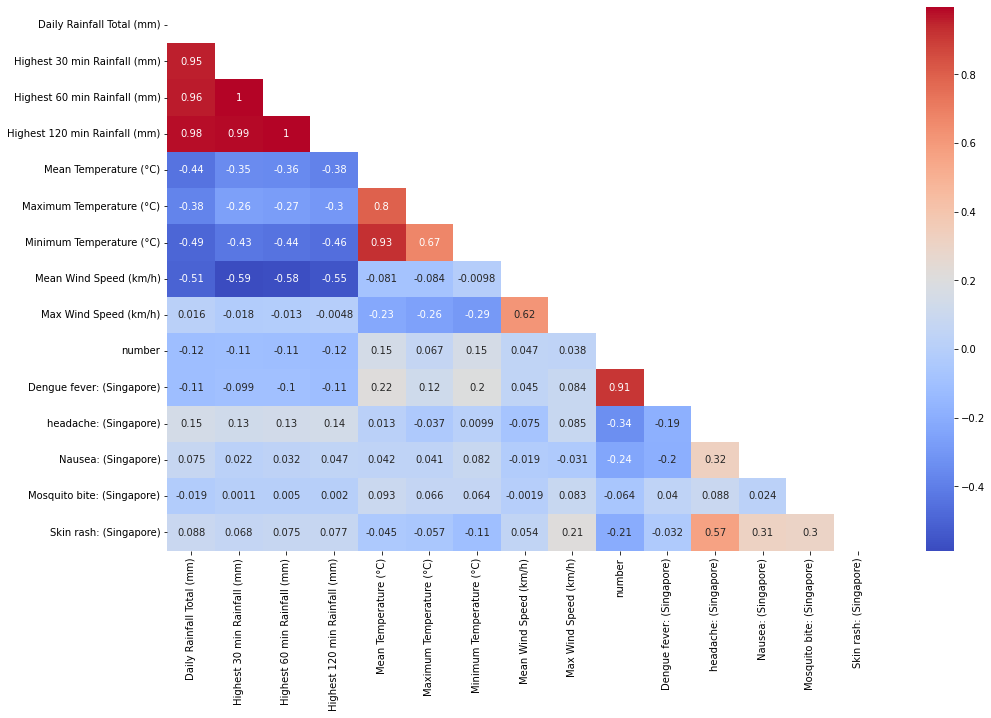

In [37]:
# Checking the correlation
mask = np.zeros_like(dfs.corr())
mask[np.triu_indices_from(mask)] = True 
plt.figure(figsize=(16,10))
sns.heatmap(dfs.corr(),annot=True,cmap='coolwarm',mask=mask);

At first glance, we observe the only feature with very strong correlation (0.91) with the number of cases is the search of "Dengue fever" in google. **This is understandable as people tend to search for dengue fever when the news about the increase of dengue fever is released.** Although symtoms such as nausea, headache and skin rash are common in dengue fever, but people tend to search dengue fever directly.

Aside from the google trend data, it seems that temperature has quite low correlation to the number of case.

### Dengue Case Heat Map (Spatial Analysis)
Understanding how the dengue case outbreak distribution in Singapore map

Reference: [Link](https://towardsdatascience.com/lets-plot-airbnb-prices-on-a-map-of-singapore-ddbcae44fb69)

We will use the data from [Outbreak.sg](https://outbreak.sgcharts.com/data) to do our spatial analysis with corner bounds of 1.15N,103.5E & 1.50N,104E



In [38]:
sp_df = pd.read_csv('../data/dengue_case.csv')
#dropping unnecessary columns
sp_df = sp_df.drop(['Unnamed: 0'], axis=1)
#updating date to match our datetime format
sp_df['date'] = pd.to_datetime(sp_df['date'], format='%y%m%d',yearfirst=True)
sp_df.sort_values(by='date',inplace=True)
sp_df.head()

,no_case,address,latitude,longitude,cluster_no,recent_case_cluster,total_case_cluster,date,month
24491,1,kang ching road (block 346),1.340296,103.720809,39,2,2,2014-01-06,1
24455,1,yishun ring road (block 395),1.428922,103.847236,19,1,4,2014-01-06,1
24456,1,yishun ring road (block 398),1.435376,103.797707,19,1,4,2014-01-06,1
24457,2,balestier road (near jalan dusun),1.326611,103.843911,20,2,3,2014-01-06,1
24458,1,jalan raja udang,1.327594,103.842287,20,2,3,2014-01-06,1


### Looking at the Centroids using K-Means Clustering

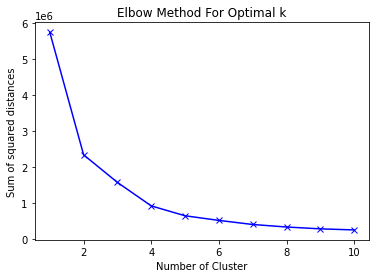

In [39]:
X = sp_df.loc[:, ['latitude', 'longitude']]
Y = sp_df['total_case_cluster']
sc = StandardScaler()
X_sc = sc.fit_transform(X)

#finding the most optimal number of 
sum_of_squared_distances = []
K = range(1,11)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters,random_state=0,max_iter=1000)
    kmeans.fit(X_sc,sample_weight = Y) #putting weights based on the total number of case in cluster
    sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,sum_of_squared_distances,'bx-')
plt.xlabel('Number of Cluster') 
plt.ylabel('Sum of squared distances') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
#finding out top 8 clusters as after 8 the drop is insignificant
kmeans = KMeans(n_clusters=8,random_state=0,max_iter=1000)
kmeans.fit(X_sc,sample_weight = Y)

## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(
    sc.inverse_transform(kmeans.cluster_centers_),
    columns=["Latitude", "Longitude"]
)
centroids

,Latitude,Longitude
0,1.357561,103.946310
1,1.379080,103.868603
2,1.306131,103.838893
3,1.341684,103.709469
4,1.437334,103.809485
5,1.352729,103.865674
6,1.318858,103.899753
7,1.378721,103.745003


### Drawing the Centroid in SG Map

In [41]:
singapore_img = mpimg.imread('../data/sgmap.png')
def  plot_year(df,start,end):
    pl_df = df[(df['date'] > start) & (df['date'] < end)]
    # plot the data
    ax = pl_df.plot(
        kind="scatter", 
        x="longitude", 
        y="latitude", 
        figsize=(16,10),
        c="total_case_cluster", 
        cmap=plt.get_cmap("jet"),
        colorbar=True, 
        alpha=0.4,
    )

    # use our map with it's bounding coordinates
    plt.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.5)      

    # add axis labels
    plt.ylabel("Latitude", fontsize=20)
    plt.xlabel("Longitude", fontsize=20)

    #draw the centroids
    centroids.plot(
    kind="scatter", 
    x="Longitude", y="Latitude", 
    marker="*", c=["#FF8000", #orange
                    "#FFD700",#yellow
                    "#9AFF9A",#lightgreen 
                    "#548B54",#darkgreen
                    "#FF34B3",#brightpink
                    "#AB82FF",#purple
                    "#FFB6C1",#softpink
                    "#808080"],#gray
    s=550,
    ax=ax
    )
    plt.title('Top 8 Cluster Based on K-Means Clustering');

    # set the min/max axis values - these must be the same as above
    plt.ylim(1.15, 1.50)
    plt.xlim(103.5, 104)
    plt.legend(fontsize=20)
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


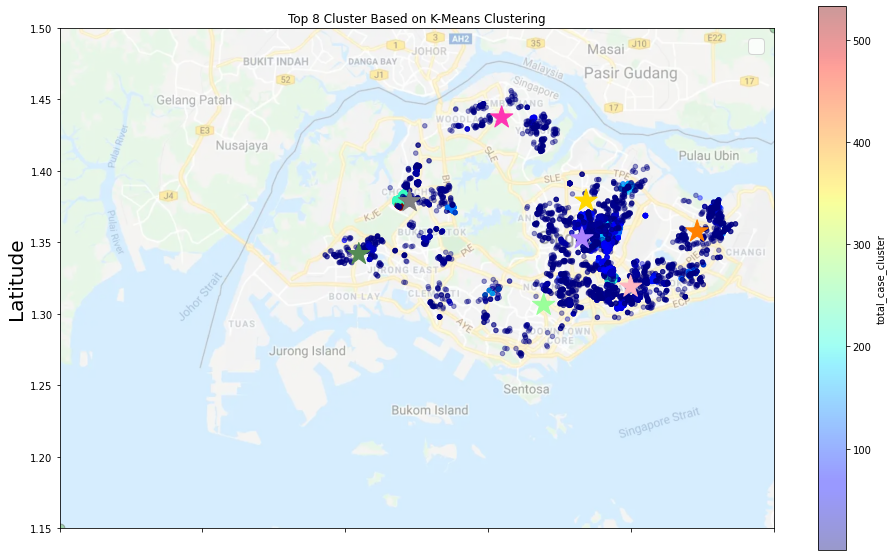

In [42]:
plot_year(sp_df,"2014-01-01","2014-12-31") #the east tend to have higher number of case

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


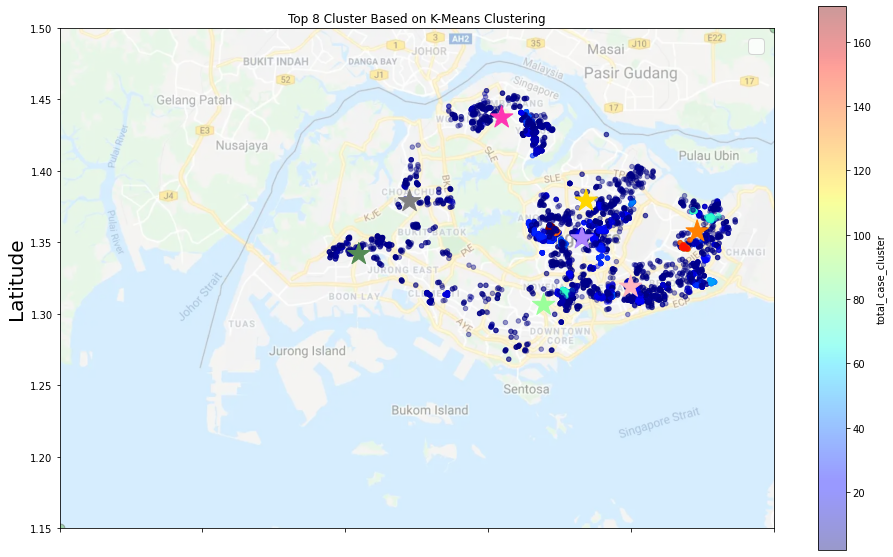

In [43]:
plot_year(sp_df,"2015-01-01","2015-12-31")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


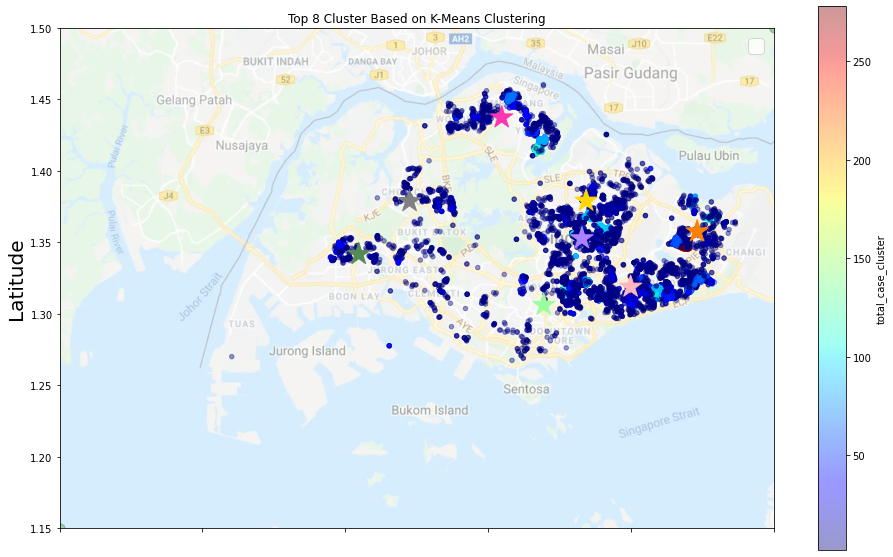

In [44]:
plot_year(sp_df,"2016-01-01","2016-12-31")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


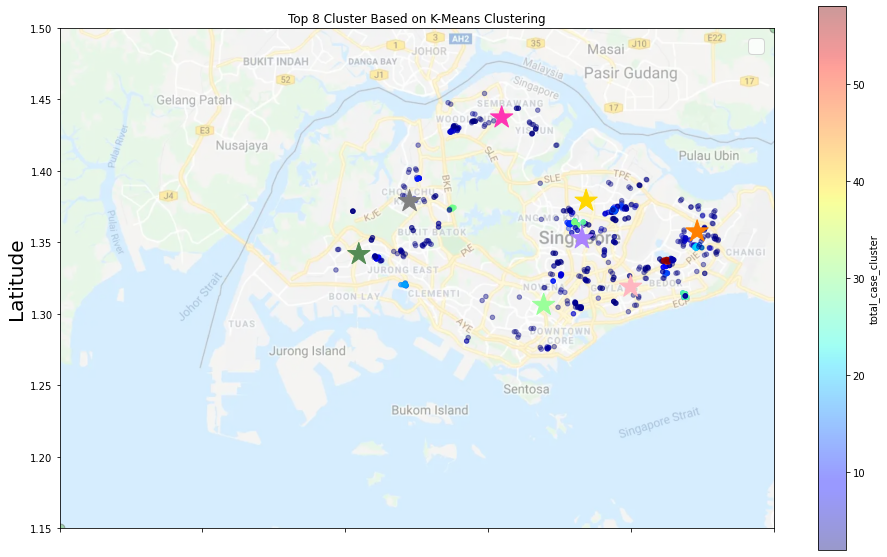

In [45]:
plot_year(sp_df,"2017-01-01","2017-12-31")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


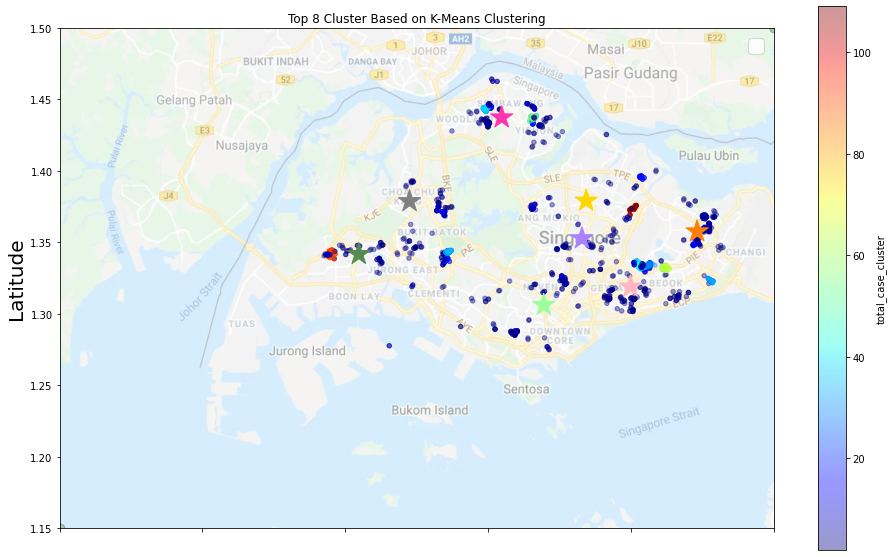

In [46]:
plot_year(sp_df,"2018-01-01","2018-12-31")

There are 8 top centroids found through the K-mean clustering by weighing the total number of cases. In the case of prioritization, **we would start to do fogging on these 5 out of 8 centroids** (4 in the east and 1 in the northwest) then followed by Jurong West, Choa Chu Kang and then Newton subsequently

8 Centroids
||Latitude|Longitude|Address|
|---|---|---|---|
|Centroids 1|1.357561|103.946310| **[Top5]** 70 Tampines Avenue 4, Singapore, 529681|
|Centroids 2|1.379080|103.868603| **[Top5]** 5006 Ang Mo Kio Avenue 5, Singapore, 569873|
|Centroids 3|1.306131|103.838893| [8] 8 Cairnhill Circle, Singapore, 229814 (Newton)|
|Centroids 4|1.341684|103.709469| [6] 25 Boon Lay Drive, Singapore, 649922 (Jurong West)|
|Centroids 5|1.437334|103.809485| **[Top5]** Woodlands Avenue 12, Singapore|
|Centroids 6|1.352729|103.865674| **[Top5]** 250 Lorong Chuan, Singapore, 556748 (Serangoon)|
|Centroids 7|1.318858|103.899753| **[Top5]** 410 Eunos Road 5, Singapore, 400410|
|Centroids 8|1.378721|103.745003| [7] 251A Choa Chu Kang Avenue 2, Singapore, 681251|

### Checking the Fluctuation of the Number of Case 

In [47]:
def plot_case(df,start,end):
    pl_df = df[(df['date'] > start) & (df['date'] < end)]
    pl_df['month']= pl_df['date'].dt.month
    pl_df.groupby(['month'])[['number']].sum().plot()
    plt.ylabel('Number of Cases')

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/601407158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['month']= pl_df['date'].dt.month


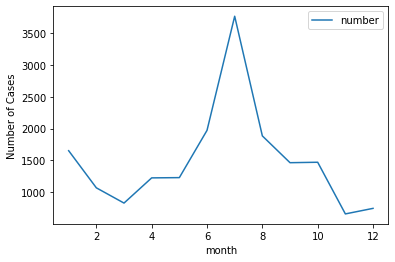

In [48]:
plot_case(dfs,'2014-01-01','2014-12-31')

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/601407158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['month']= pl_df['date'].dt.month


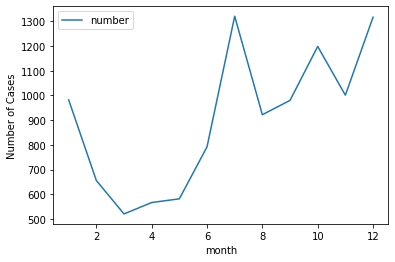

In [49]:
plot_case(dfs,'2015-01-01','2015-12-31')

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/601407158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['month']= pl_df['date'].dt.month


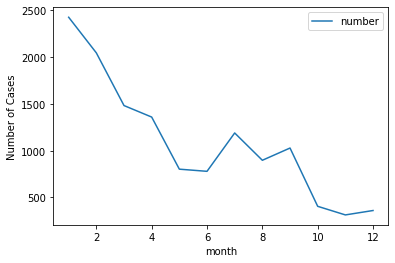

In [50]:
plot_case(dfs,'2016-01-01','2016-12-31')

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/601407158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['month']= pl_df['date'].dt.month


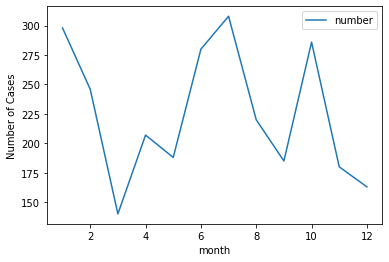

In [51]:
plot_case(dfs,'2017-01-01','2017-12-31')

/var/folders/tg/8mpzp58s7wd9h25zt2bffqd00000gn/T/ipykernel_14079/601407158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_df['month']= pl_df['date'].dt.month


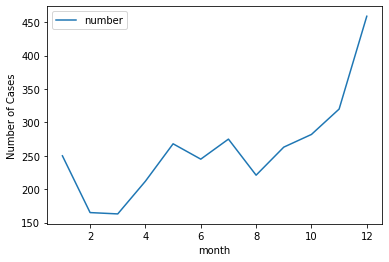

In [52]:
plot_case(dfs,'2018-01-01','2018-12-31')

Throughout the years (2014-2018), July has been the peak for dengue case which is expected as the weather tend to be warmer from June to October, which shows **seasonality** of the target varible we are tracking here. For October peak, this might due to the delayed rain as there will be stagnant water, conducive for mosquito breeding.

The first quarter of the year, there is a tendency for the case to be decreasing only to go up and peak around July.

This shows how we can put our resources efficiently by **putting more fogging sessions on June (due to 2 weeks incubation, mosquitoes might breed during this timing) to October**.

# Modeling

In [53]:
#create time series features based on the date
dfs['quarter'] = dfs['date'].dt.quarter
dfs['month'] = dfs['date'].dt.month
dfs.set_index('date', inplace=True)
dfs.head()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore),quarter,month
date,,,,,,,,,,,,,,,,,
2014-01-08,4.013191,2.495814,3.053953,3.513953,26.521429,29.771111,24.455556,8.748889,32.664706,437,18,67,48,2,69,1,1
2014-01-15,7.426140,2.840864,3.327907,3.905980,26.502521,30.072222,24.260800,7.839683,31.030252,479,18,67,48,2,69,1,1
2014-01-22,0.023708,0.019269,0.019934,0.019934,26.245378,29.387302,24.087302,12.849206,39.256303,401,18,67,48,2,69,1,1
2014-01-29,0.000000,0.000000,0.000000,0.000000,25.783193,29.365079,23.442857,12.439683,37.311765,336,18,67,48,2,69,1,1
2014-02-05,0.000000,0.000000,0.000000,0.000000,26.210256,30.846825,23.257143,12.272222,37.343697,234,18,68,55,6,70,1,2


In [54]:
#creating lag feature, help for training our model
dfs['number_lag1'] = dfs['number'].shift(1)
dfs['number_lag2'] = dfs['number'].shift(2) #by 2 weeks (based on incubation period)
dfs['number_lag4'] = dfs['number'].shift(4) #by 4 weeks (approx 1 month)
dfs = dfs.dropna()
dfs.head()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number,Dengue fever: (Singapore),headache: (Singapore),Nausea: (Singapore),Mosquito bite: (Singapore),Skin rash: (Singapore),quarter,month,number_lag1,number_lag2,number_lag4
date,,,,,,,,,,,,,,,,,,,,
2014-02-05,0.000000,0.000000,0.000000,0.000000,26.210256,30.846825,23.257143,12.272222,37.343697,234,18,68,55,6,70,1,2,336.0,401.0,437.0
2014-02-12,0.821277,0.481063,0.562791,0.590698,26.703361,31.804762,23.677778,9.371429,29.007563,274,18,68,55,6,70,1,2,234.0,336.0,479.0
2014-02-19,1.429787,0.972757,1.329568,1.442525,27.595798,32.432540,24.667460,11.303175,35.091597,369,18,68,55,6,70,1,2,274.0,234.0,401.0
2014-02-26,0.081194,0.069707,0.076873,0.076873,27.610256,31.966667,24.898413,12.693651,38.407563,194,18,68,55,6,70,1,2,369.0,274.0,336.0
2014-03-05,0.018935,0.020000,0.020645,0.020645,27.472500,32.266929,24.448031,12.129687,37.020661,187,14,52,55,8,56,1,3,194.0,369.0,234.0


In [55]:
#train test split data
train = dfs.dropna().iloc[:206] #dropping first few rows due to the lag
test = dfs.dropna().iloc[206:]
X_train = train.drop(columns=['number'])
y_train = train['number']
X_test = test.drop(columns=['number'])
y_test = test['number']

### Baseline Model

Taking the mean of the dengue case over 2014-2018 and calculating the RMSE

In [56]:
y_mean = dfs['number'].mean()
np.sqrt(((dfs['number']-y_mean)**2).sum()/dfs.shape[0]) #rmse

157.35563820530868

### Linear Regression

In [57]:
def linear_regression(X_train, X_test, y_train, y_test):
    model_1_pipe = Pipeline([
        ('ss',MinMaxScaler()),
        ('lr',LinearRegression())
    ])
    model_1_pipe.fit(X_train,y_train);
    train_acc = model_1_pipe.score(X_train,y_train)
    test_acc = model_1_pipe.score(X_test,y_test)
    y_pred = model_1_pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(y_test, y_pred,s=5)
    ax.set_title('Linear Regression Prediction Distribution',fontsize=14)
    ax.set_xlabel('True Number of Cases',fontsize=10)
    ax.set_ylabel('Predicted Number of Cases',fontsize=10)
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="r")

    #output
    print('Linear Model Score-------')
    print(f'Train Score: {train_acc}; Test Score: {test_acc}')
    print(f'RMSE for this model: {rmse}')
    

    return train_acc,test_acc,rmse,y_pred,model_1_pipe

Linear Model Score-------
Train Score: 0.9320306738052337; Test Score: 0.05806570466044636
RMSE for this model: 25.027530118482883


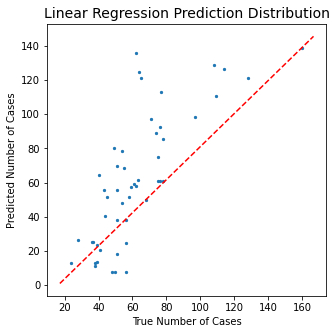

In [58]:
lr_train_score, lr_test_score, lr_rmse,lr_pred,model1lr = linear_regression(X_train, X_test, y_train, y_test) #overfitting is observed, unable to generalize

In [59]:
# square root on both features and target
X_train_sq = np.sqrt(train.drop(columns=['number'])) 
y_train_sq = np.sqrt(train['number'])
X_test_sq = np.sqrt(test.drop(columns=['number']))
y_test_sq = np.sqrt(test['number'])

Linear Model Score-------
Train Score: 0.9443789028210777; Test Score: 0.5700603207383204
RMSE for this model: 0.9878153782474645


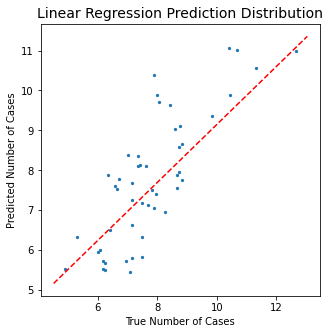

In [60]:
lr_train_score_log, lr_test_score_log, lr_rmse_log,y_pred_log,model1sq = linear_regression(X_train_sq, X_test_sq, y_train_sq, y_test_sq)

In [61]:
y_pred = np.square(y_pred_log)
np.sqrt(((y_test-y_pred)**2).sum()/y_test.shape[0]) #RMSE of Linear Regression 

16.12430053731648

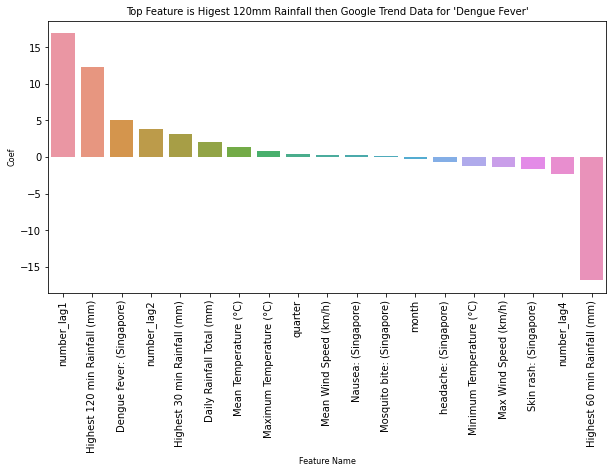

In [62]:
feature_names = model1sq.feature_names_in_
coefs= model1sq.named_steps['lr'].coef_.flatten()
df_coef = pd.DataFrame(zip(feature_names,coefs), columns=["feature", "value"])
df_coef = df_coef.sort_values("value", ascending=False)

#visualizing the feature importance
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.barplot(x="feature",
            y="value",
            data=df_coef)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
ax.set_title("Top Feature is Higest 120mm Rainfall then Google Trend Data for 'Dengue Fever'", fontsize=10)
ax.set_ylabel("Coef", fontsize=8)
ax.set_xlabel("Feature Name", fontsize=8);

Linear Regression model shows **severe overfitting** problem although the RMSE shows huge improvement from baseline model from 157.36 to 25.03 for using our baseline data. **Further observation on square root transformed data, we observed significant increase of R2 score performance from 1% to 57% and RMSE at 16.12** .

### XGBoost

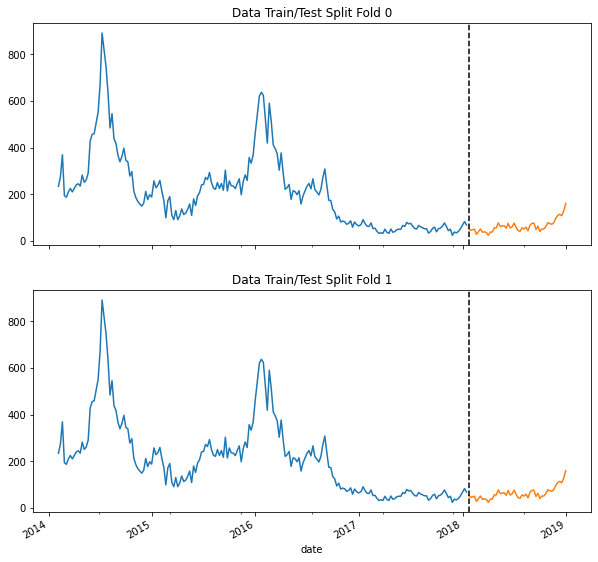

In [63]:
tss = TimeSeriesSplit(n_splits=2,test_size =52)
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(dfs):
    train['number'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['number'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [64]:
tss = TimeSeriesSplit(n_splits=2,test_size =52) #using cross validation

fold = 0
preds = []
accuracy = []
scores = []
for train_idx, val_idx in tss.split(dfs):
    train = dfs.iloc[train_idx]
    test = dfs.iloc[val_idx]

    X_train = train.drop(columns=['number'])
    y_train = train['number']
    X_test = test.drop(columns=['number'])
    y_test = test['number']
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')    

[22:15:34] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:306.09012	validation_1-rmse:53.84375
[100]	validation_0-rmse:126.92718	validation_1-rmse:15.82213
[141]	validation_0-rmse:91.74063	validation_1-rmse:20.64220
[22:15:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:265.62592	validation_1-rmse:66.94931
[100]	validation_0-rmse:110.08575	validation_1-rmse:28.82878
[200]	validation_0-rmse:53.26921	validation_1-rmse:19.53609
[300]	validation_0-rmse:33.35889	validation_1-rmse:18.94628
[313]	validation_0-rmse:31.99339	validation_1-rmse:19.00743
Score across folds 17.1541
Fold scores:[15.452671450222434, 18.855545757424874]


In [65]:
tss = TimeSeriesSplit(n_splits=2,test_size =52) #using cross validation on square rooted features

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(dfs):
    train = dfs.iloc[train_idx]
    test = dfs.iloc[val_idx]

    X_train = np.sqrt(train.drop(columns=['number']))
    y_train = np.sqrt(train['number'])
    X_test = np.sqrt(test.drop(columns=['number']))
    y_test = np.sqrt(test['number'])

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(np.square(y_test), np.square(y_pred))) #returning it back
    scores.append(score)

print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')    

[22:15:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:15.76777	validation_1-rmse:6.70053
[100]	validation_0-rmse:6.12043	validation_1-rmse:1.53283
[197]	validation_0-rmse:2.63815	validation_1-rmse:1.29307
[22:15:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:14.02859	validation_1-rmse:7.38001
[100]	validation_0-rmse:5.44294	validation_1-rmse:2.83060
[200]	validation_0-rmse:2.29290	validation_1-rmse:1.36909
[300]	validation_0-rmse:1.20334	validation_1-rmse:1.04053
[400]	validation_0-rmse:0.86978	validation_1-rmse:1.00250
[417]	validation_0-rmse:0.84174	validation_1-rmse:1.00200
Score across folds 16.0775
Fold scores:[15.2254957

XGBoost Model performs better than baseline but still below linear regression of square rooted features. On top of that, **the downside of using XGBoost is that this is a black box model**, therefore, it is hard to interpret which feature is more important.

### Long Short Term Mermory (LSTM)
Using deep learning to try forecasting number of dengue case

In [66]:
features =[
       'number','Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'Dengue fever: (Singapore)',
       'headache: (Singapore)', 'Nausea: (Singapore)',
       'Mosquito bite: (Singapore)', 'Skin rash: (Singapore)', 'quarter',
       'month', 'number_lag4', 'number_lag2', 'number_lag1'
]
check = dfs[features]

In [67]:
mm = StandardScaler()
c_train_sc = mm.fit_transform(train)
c_test_sc = mm.transform(test)

In [68]:
n_past = 4
n_future = 1
trainX = []
trainY = []
testX = []
testY = []

#transforming dta to a 3 dimensional moving data as per required by our model
for i in range(n_past, len(c_train_sc)- n_future + 1):
    trainX.append(c_train_sc[i - n_past:i,1:c_train_sc.shape[1]])
    trainY.append(c_train_sc[(i + n_future-1): (i + n_future),0])

trainX,trainY = np.array(trainX),np.array(trainY) #taking past 4 week data to predict the next (5th one) and so one
for i in range(n_past, len(c_test_sc)- n_future + 1):
    testX.append(c_test_sc[i - n_past:i,1:c_test_sc.shape[1]])
    testY.append(c_test_sc[(i + n_future-1): (i + n_future),0])
testX,testY = np.array(testX),np.array(testY)
print(f'train X shape = {trainX.shape}')
print(f'train Y shape = {trainY.shape}') #4rows missing 
print(f'test X shape = {testX.shape}')
print(f'test Y shape = {testY.shape}') #4rows missing 

train X shape = (200, 4, 19)
train Y shape = (200, 1)
test X shape = (48, 4, 19)
test Y shape = (48, 1)


In [69]:
model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True)) #would like to have next LSTM to feed this output
model.add(LSTM(32,activation='relu',return_sequences=False))
#model.add(Dropout(0.2)) 
model.add(Dense(1))

opt = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt)
model.summary()

2023-01-30 22:15:37.230122: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             21504     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 33,953
Trainable params: 33,953
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
20/20 [==============================] - 3s 28ms/step - loss: 0.9739 - val_loss: 1.1333
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9687 - val_loss: 1.1287
Epoch 3/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9637 - val_loss: 1.1241
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.9589 - val_loss: 1.1205
Epoch 5/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9544 - val_loss: 1.1164
Epoch 6/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9496 - val_loss: 1.1120
Epoch 7/30
20/20 [==============================] - 0s 6ms/step - loss: 0.9447 - val_loss: 1.1081
Epoch 8/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9397 - val_loss: 1.1041
Epoch 9/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9345 - val_loss: 1.0994
Epoch 10/30
20/20 [==============================] - 0s 5ms/step - loss: 0.9296 - val_loss: 1.0943
Epoch 11/30
20/20 

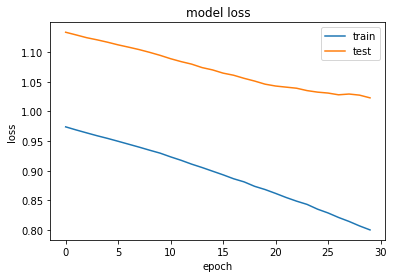

In [70]:
history = model.fit(trainX,trainY, validation_data=(testX, testY),epochs=30,batch_size=10, verbose=1)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [71]:
testX.shape

(48, 4, 19)

In [72]:
# make a prediction
y_pred = model.predict(testX)
prediction_copies = np.repeat(y_pred, 20, axis=-1)
inv_yhat = mm.inverse_transform(prediction_copies) #inversing it back to actual number
inv_yhat = pd.DataFrame(inv_yhat)
inv_yhat.iloc[0].head()

2/2 [==============================] - 0s 3ms/step


0     5.387913
1     3.376036
2     4.132140
3     4.613593
4    27.994598
Name: 0, dtype: float32

In [73]:
c_pred = pd.concat([test['number'].iloc[4:].reset_index(), inv_yhat.iloc[:,0].reset_index()], axis=1).drop(columns='index')
c_pred.rename(columns={'number':'Actual',0:'Prediction'},inplace=True)
np.sqrt(mean_squared_error(c_pred['Actual'],c_pred['Prediction']))

61.75320891680587


# Time Series Analysis


### Stationary Test
As VectorARIMA requires time series to be stationary, we will use one popular statistical test – Augmented Dickey-Fuller Test (ADF Test) to check the stationary of each variable in the dataset.  

The Null Hypothesis is that the data has unit root and is not stationary and the significant value is 0.05.

In [74]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 5) 
    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
        
for name, column in dfs.iteritems():
    adfuller_test(column, name=column.name)

 Daily Rainfall Total (mm) : P-Value = 0.0 => Stationary. 
 Highest 30 min Rainfall (mm) : P-Value = 0.0 => Stationary. 
 Highest 60 min Rainfall (mm) : P-Value = 0.0 => Stationary. 
 Highest 120 min Rainfall (mm) : P-Value = 0.0 => Stationary. 
 Mean Temperature (°C) : P-Value = 0.00057 => Stationary. 
 Maximum Temperature (°C) : P-Value = 0.0 => Stationary. 
 Minimum Temperature (°C) : P-Value = 0.00013 => Stationary. 
 Mean Wind Speed (km/h) : P-Value = 0.0 => Stationary. 
 Max Wind Speed (km/h) : P-Value = 6e-05 => Stationary. 
 number : P-Value = 0.15566 => Non-stationary.
 Dengue fever: (Singapore) : P-Value = 0.027 => Stationary. 
 headache: (Singapore) : P-Value = 0.01429 => Stationary. 
 Nausea: (Singapore) : P-Value = 0.00027 => Stationary. 
 Mosquito bite: (Singapore) : P-Value = 0.00211 => Stationary. 
 Skin rash: (Singapore) : P-Value = 0.04625 => Stationary. 
 quarter : P-Value = 0.00521 => Stationary. 
 month : P-Value = 0.00953 => Stationary. 
 number_lag1 : P-Value = 0

#### Findings:
From the results above, we could see none of these varibles is stationary. Let us use the differencing method to make them stationary.

In [75]:
# diff data
data = df.drop(columns=['week', 'year'])
data.set_index('date', inplace=True)
data = data.diff().dropna()

data.head()

,Daily Rainfall Total (mm),Highest 30 min Rainfall (mm),Highest 60 min Rainfall (mm),Highest 120 min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),number
date,,,,,,,,,,
2014-01-15,3.412948,0.345050,0.273953,0.392027,-0.018908,0.301111,-0.194756,-0.909206,-1.634454,42.0
2014-01-22,-7.402432,-2.821595,-3.307973,-3.886047,-0.257143,-0.684921,-0.173498,5.009524,8.226050,-78.0
2014-01-29,-0.023708,-0.019269,-0.019934,-0.019934,-0.462185,-0.022222,-0.644444,-0.409524,-1.944538,-65.0
2014-02-05,0.000000,0.000000,0.000000,0.000000,0.427063,1.481746,-0.185714,-0.167460,0.031933,-102.0
2014-02-12,0.821277,0.481063,0.562791,0.590698,0.493105,0.957937,0.420635,-2.900794,-8.336134,40.0


## Train-Test Split

In [76]:
data.columns

Index(['Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)', 'number'],
      dtype='object')

In [77]:
test_obs = int(len(data) * 0.2)
train = data[:-test_obs]
test = data[-test_obs:]

# for ARIMA
endog = train[['number']]
exog = train[['Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)']]
test_exog = data[-test_obs:][['Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)']]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


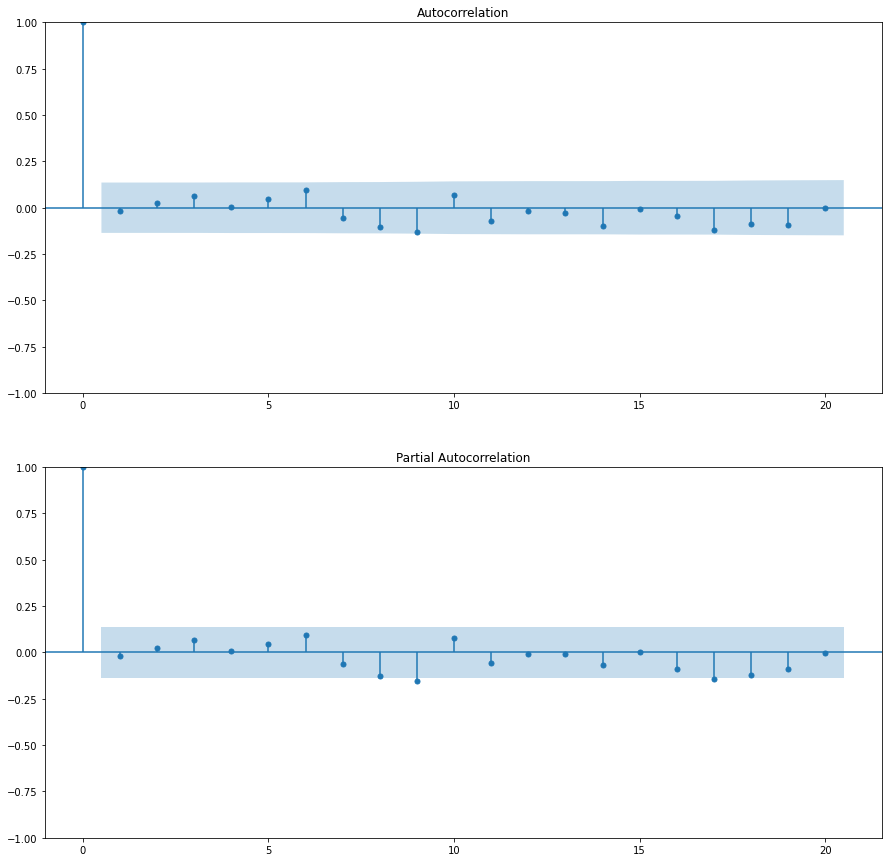

In [78]:
# Generate autocorrelation plot on training data.
fig, ax = plt.subplots(2,1,figsize=(15, 15))
plot_acf(train['number'], lags = 20,ax=ax[0]);
plot_pacf(train['number'], lags = 20,ax=ax[1]);

#### Findings: 
Both the ACF and PACF show a gradual decay, an ARMA model is likely appropriate as opposed to AR or MA alone. Since there are multiple variables, I will use vector ARIMA model to fit data.

## Model

### Vector Auto Regression (VAR)
https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/#:~:text=A%20Multivariate%20time%20series%20has,used%20for%20forecasting%20future%20values.

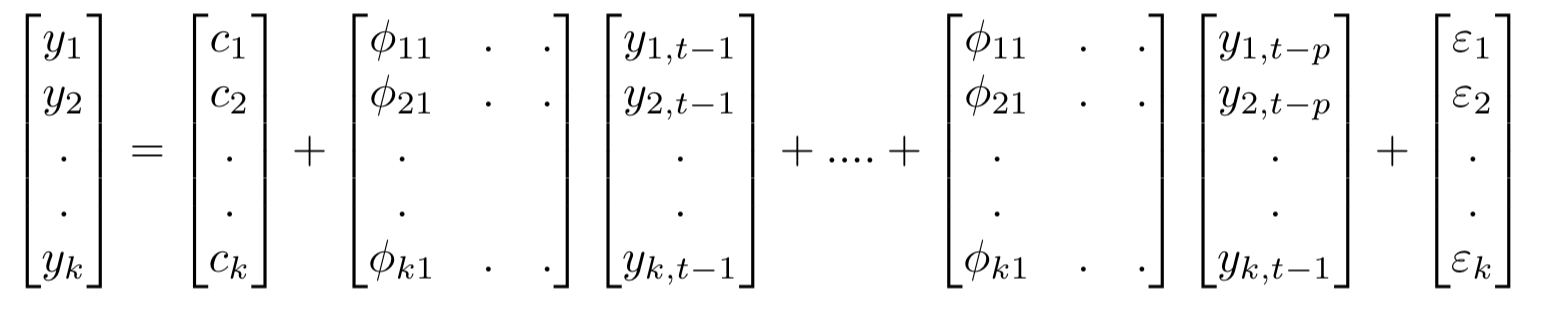

In [79]:
model = VAR(train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [80]:
x = model.select_order(maxlags=16)
x.summary()

,AIC,BIC,FPE,HQIC
0,2.117,2.287*,8.309,2.186
1,0.9953,2.862,2.709,1.751*
2,0.5215,4.084,1.699,1.965
3,0.4444,5.704,1.605*,2.574
4,0.5515,7.508,1.856,3.369
5,0.8288,9.482,2.610,4.333
6,1.000,11.35,3.414,5.192
7,1.057,13.10,4.157,5.936
8,1.225,14.97,5.970,6.791
9,1.148,16.59,7.186,7.401


In [81]:
results_aic = []
results_bic = []
results_hqic = []
for p in range(1,10):
    results = model.fit(p)
    results_aic.append(results.aic)
    results_bic.append(results.bic)
    results_hqic.append(results.hqic)
pd.DataFrame({'AIC Result':results_aic,'BIC Result':results_bic,'HQIC Result':results_hqic})

,AIC Result,BIC Result,HQIC Result
0,0.970050,2.741060,1.686231
1,0.395513,3.788008,1.767552
2,0.315803,5.340843,2.348311
3,0.469524,7.138294,3.167162
4,0.723915,9.047733,4.091399
5,0.905301,10.895615,4.947400
6,0.968859,12.637249,5.690396
7,1.119730,14.477915,6.525583
8,1.187158,16.246994,7.282263


Text(0, 0.5, 'HQIC')

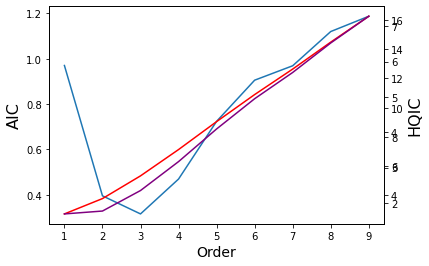

In [82]:
#define subplots
fig,ax = plt.subplots()
#add first line to plot
ax.plot(list(np.arange(1,10,1)), results_aic)
#add x-axis label
ax.set_xlabel('Order', fontsize=14)
#add y-axis label
ax.set_ylabel('AIC', fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
#add second line to plot
ax2.plot(list(np.arange(1,10,1)), results_bic, color='red')
#add second y-axis label
ax2.set_ylabel('BIC', fontsize=16)

#define third y-axis that shares x-axis with current plot
ax3 = ax.twinx()
#add third line to plot
ax3.plot(list(np.arange(1,10,1)), results_hqic, color ='Purple')
#add third y-axis label
ax2.set_ylabel('HQIC', fontsize=16)

In [83]:
p = 3
results =  model.fit(p)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 30, Jan, 2023
Time:                     22:15:47
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    5.34084
Nobs:                     205.000    HQIC:                   2.34831
Log likelihood:          -2631.19    FPE:                    1.40379
AIC:                     0.315803    Det(Omega_mle):        0.343338
--------------------------------------------------------------------
Results for equation Daily Rainfall Total (mm)
                                      coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------------
const                                    0.124768         0.304415            0.410           0.682
L1.Daily Rainfall Total (mm)            -0.907450         0.3987

In [84]:
# make predictions
pred = results.forecast(results.endog, steps = test_obs)
pred = pd.DataFrame(pred, columns = data.columns + '_pred')
#pred

In [85]:
d = data.tail(test_obs)
pred.index = d.index

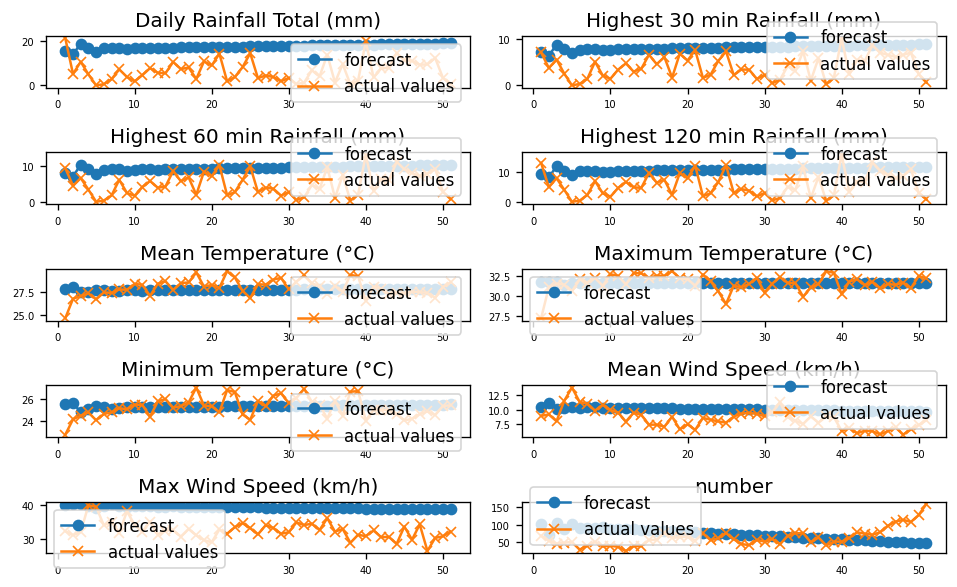

In [86]:
def plot_forecast_actuals(data, data_actual, data_predict):
    fig, axes = plt.subplots(nrows=int(len(data_actual.columns)/2), ncols=2, dpi=120, figsize=(8,5))
    for i, (col,ax) in enumerate(zip(data_actual.columns, axes.flatten())):
        ax.plot(list(np.arange(1,test_obs+1,1)),data_predict[col + '_pred'], label='forecast', marker='o')
        ax.plot(list(np.arange(1,test_obs+1,1)),data_actual[col], label='actual values', marker='x')
        ax.legend(loc='best')
        ax.set_title(data.columns[i])
        ax.set_title(col)
        ax.tick_params(labelsize=6)
    
    plt.tight_layout();
def invert_transformation(endog_train,pred):
    forecast = pred.copy()
    columns = endog_train.columns
    for col in columns:
        forecast[str(col)+'_pred'] = endog_train[col].iloc[-1] +   forecast[str(col) +'_pred'].cumsum()
    return forecast

output = invert_transformation( df[['Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)','number']].head(len(df)-test_obs-1), pred)

plot_forecast_actuals(data=data, data_actual=df[['Daily Rainfall Total (mm)', 'Highest 30 min Rainfall (mm)',
       'Highest 60 min Rainfall (mm)', 'Highest 120 min Rainfall (mm)',
       'Mean Temperature (°C)', 'Maximum Temperature (°C)',
       'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
       'Max Wind Speed (km/h)','number']].tail(test_obs), data_predict = output)

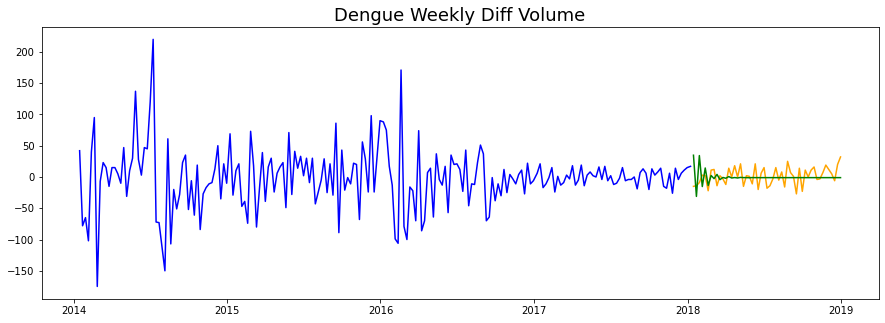

In [87]:
# Plot data.
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(pred['number_pred'], color = 'green')

plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

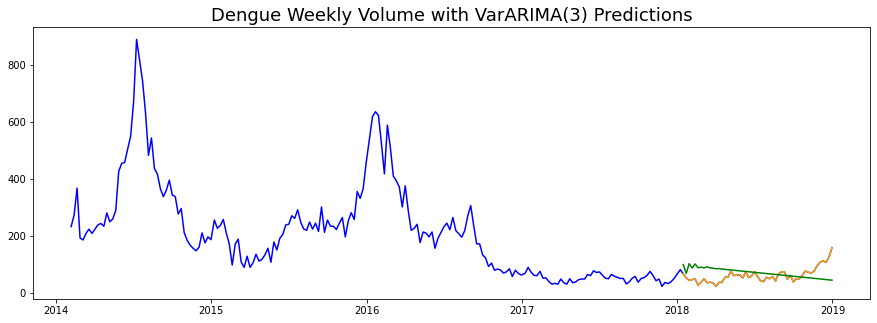

In [88]:
#transforming it back to the value
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(dfs['number'], color = 'blue')
plt.plot(dfs['number'].tail(test_obs), color = 'orange')
plt.plot(output['number_pred'], color = 'green')         
plt.title(label = f'Dengue Weekly Volume with VarARIMA({p}) Predictions', fontsize=18)
plt.show();

In [89]:
# Evaluate predictions.
np.sqrt(mean_squared_error(test['number'], pred['number_pred']))

16.81707024613097

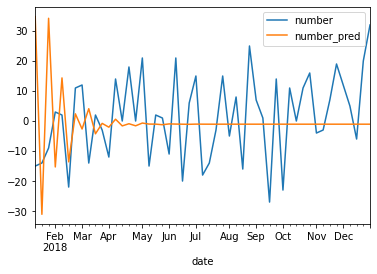

In [91]:
res1 =  pd.concat([test,pred['number_pred']],axis=1)
res1[['number','number_pred']].plot()
res1['diff'] = res1['number']-res1['number_pred']


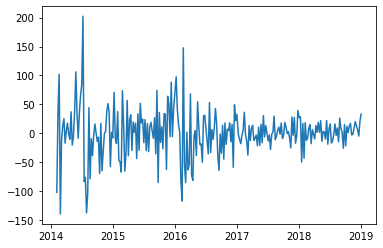

In [92]:
# residual plot
var_res = pd.concat([results.resid['number'], res1['diff']])
plt.plot(var_res)

## Findings:
The residual plot depicts variance change, which indicates that model variance is not constant over time.

## SARIMA

In [93]:
sarima_model1 = auto_arima(
                        y=endog, 
                        X=exog,
                        start_p=1, 
                        start_q=1,
                        max_p=8, 
                        max_q=8, 
                        m=4,    # quaterly
                        start_P=0, 
                        max_P = 4,
                        max_Q = 4,
						seasonal=True,
                        d=1, 
                        #D=1, 
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=2345.416, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=2288.193, Time=0.60 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=2343.417, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=2286.526, Time=0.47 sec
 ARIMA(1,1,0)(0,0,1)[4] intercept   : AIC=2288.007, Time=0.57 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=2288.409, Time=0.64 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=2260.630, Time=0.51 sec
 ARIMA(2,1,0)(1,0,0)[4] intercept   : AIC=2262.582, Time=0.66 sec
 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=2262.531, Time=0.61 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=2264.168, Time=0.72 sec
 ARIMA(3,1,0)(0,0,0)[4] intercept   : AIC=2252.956, Time=0.56 sec
 ARIMA(3,1,0)(1,0,0)[4] intercept   : AIC=2244.980, Time=0.72 sec
 ARIMA(3,1,0)(2,0,0)[4] intercept   : AIC=2

In [94]:
sarima_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  208
Model:             SARIMAX(3, 1, 0)x(4, 0, 0, 4)   Log Likelihood               -1098.975
Date:                           Mon, 30 Jan 2023   AIC                           2231.951
Time:                                   22:16:23   BIC                           2288.607
Sample:                                        0   HQIC                          2254.862
                                           - 208                                         
Covariance Type:                             opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)         5.9981      3.481      1.723      0.085      -0.824      12.820
Highest 30 min Rainfall (mm)    -13.6195     19.228     -0.708      0.479     -51.306      24.067
Highest 60 min Rainfall (mm)      4.2645     29.390      0.145      0.885     -53.338      61.867
Highest 120 min Rainfall (mm)    -2.9607     19.453     -0.152      0.879     -41.088      35.167
Mean Temperature (°C)           -17.0778     22.671     -0.753      0.451     -61.513      27.357
Maximum Temperature (°C)         15.4048     10.734      1.435      0.151      -5.634      36.443
Minimum Temperature (°C)         -2.2181     12.675     -0.175      0.861     -27.062      22.625
Mean Wind Speed (km/h)           -1.4835      4.914     -0.302      0.763     -11.114       8.147
Max Wind Speed (km/h)             0.7283      1.745      0.417      0.676      -2.692       4.148
ar.L1                            -0.9010      0.054    -16.559      0.000      -1.008      -0.794
ar.L2                            -0.7346      0.065    -11.336      0.000      -0.862      -0.608
ar.L3                            -0.6371      0.070     -9.128      0.000      -0.774      -0.500
ar.S.L4                          -0.6086      0.088     -6.898      0.000      -0.782      -0.436
ar.S.L8                          -0.4734      0.093     -5.099      0.000      -0.655      -0.291
ar.S.L12                         -0.2931      0.091     -3.213      0.001      -0.472      -0.114
ar.S.L16                         -0.1735      0.087     -1.984      0.047      -0.345      -0.002
sigma2                         2371.0446    199.287     11.898      0.000    1980.449    2761.641
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                20.05
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Findings
According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is not greater than 0.05, so we reject the null hypothesis of independence, which means the residual distribution is not constant variance because the p-value of the Heteroskedasticity test (Prob(H)) is 0, smaller than 0.05.

In [95]:
forecast,confint = sarima_model1.predict(n_periods= test_obs, X = test_exog, return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['number_pred'])
forecast.index=test.index
#forecast

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


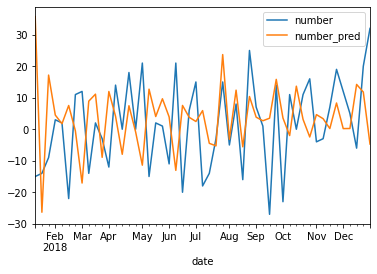

In [96]:
res = pd.concat([test,forecast],axis=1)
res[['number','number_pred']].plot()
res['diff'] = res['number']-res['number_pred']


In [97]:
pred2 = invert_transformation(endog, res[['number_pred']])
cf= pd.DataFrame(confint)

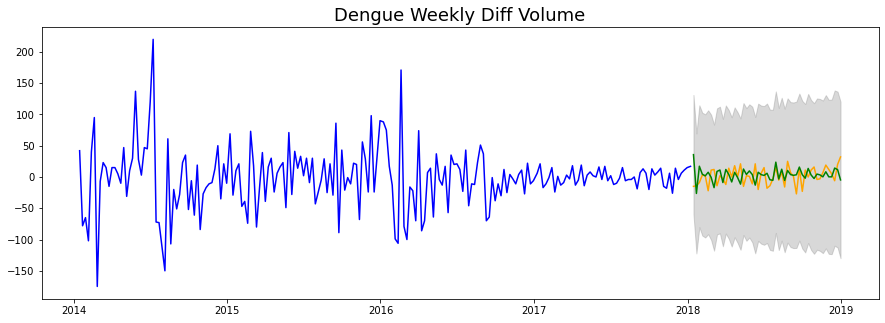

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# Plot training data in blue.
plt.plot(train['number'], color = 'blue')

# Plot testing data in orange.
plt.plot(test['number'], color = 'orange')

# Plot predicted values in green.
plt.plot(res['number_pred'], color = 'green')

ax.fill_between(forecast.index,
                cf[0],
                cf[1],color='grey',alpha=.3)
                
plt.title(label = 'Dengue Weekly Diff Volume', fontsize=18)
plt.show();

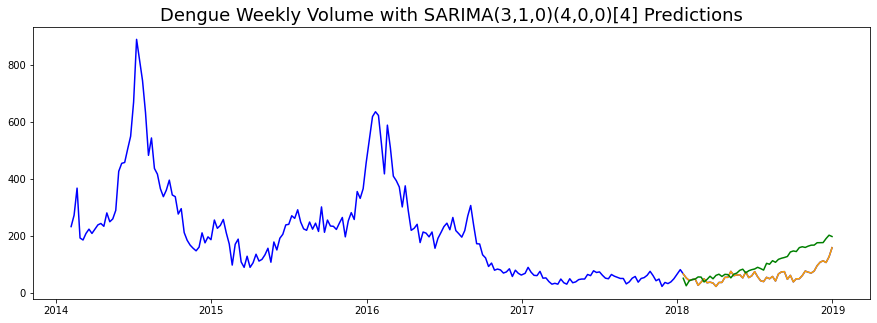

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

plt.plot(dfs['number'], color = 'blue')
plt.plot(dfs['number'].tail(test_obs), color = 'orange')
plt.plot(pred2, color = 'green')
      
plt.title(label = f'Dengue Weekly Volume with SARIMA(3,1,0)(4,0,0)[4] Predictions', fontsize=18)
plt.show();

In [100]:
np.sqrt(mean_squared_error(test['number'], res[['number_pred']]))

18.102646105150217

## Model Summary

|**Model**|**RMSE**|**Remarks**|
|---|---|---|
|Baseline|157.35|Using the mean to predict the dengue case number|
|Linear Regression|25.03| Improvement from baseline but R2 score is <1%, minmaxscaler is used as the range of these features is well defined (temp, rainfall, google trend relative interest score)|
|Linear Regression with Square Rooted Features|**16.12**|Improvement from previous LR model of R2 score to 57% and another form of normalization by square rooting the features help the model performance, lag1 is the best predictor = our model to predict **the next 1 to 2 weeks dengue case number in Singapore** based on Temp, Rainfall, and Google Trend Data|
|XGBoost|17.15|Downside that this is a blackbox model and not able to pinpoint the important features|
|XGBoost with Square Rooted Features|16.08|Downside that this is a blackbox model and not able to pinpoint the important features|
|LSTM|61.75|Transforming our data to take count of previous study based on 4 week window (predict the 5th week)- unable to perform well|
|VAR|16.82|using time series model, easily going to mean. Unable to be used for long term prediction|
|SARIMA|18.102|improvement from VAR model, but our model seems to be quite worst off than a simple linear regression model|

The overall best model is Linear Regression on square rooted features to predict the next 1 to 2 weeks dengue case. The most important features are Highest 120 min rainfall and dengue fever google trend search. **This is an interesting finding on how people leverage google trend search term and that shows how people are more interested in this topic which most of the time is when the case is increasing.**

## Exploration and Recommendation

In [105]:
#Singapore tourist data
tour = pd.read_csv('../data/sg-tourist-arrival.csv',index_col=None)
#tour.columns = tour.T.iloc[0]
tour = tour.T[1:]
tour.rename(columns={0:'southeast_tourist'},inplace=True)
tour.tail()

,southeast_tourist
2014 May,549855
2014 Apr,511901
2014 Mar,508913
2014 Feb,440212
2014 Jan,497205


In [106]:
r_df = pd.read_csv('../data/rain-humidity-sunshine.csv',index_col=None)
r_df = r_df.T[1:]
r_df.rename(columns={0:'no_rainy_days',1:'hr_sunshine',2:'min_humid_pct',3:'rltv_humid_pct'},inplace=True)
r_df.tail()
rt_df = pd.concat([tour,r_df],axis=1)
rt_df.reset_index(inplace=True)
rt_df['index'] = rt_df['index'].apply(lambda x: datetime.strptime(x,'%Y %b').strftime('%Y-%m-%d'))
rt_df['index'] = pd.to_datetime(rt_df['index'])

cols = ['southeast_tourist', 'no_rainy_days', 'hr_sunshine',
       'min_humid_pct', 'rltv_humid_pct']
for col in cols:
    rt_df[col] = rt_df[col].astype(float)
rt_df.tail()

,index,southeast_tourist,no_rainy_days,hr_sunshine,min_humid_pct,rltv_humid_pct
55,2014-05-01,549855.0,18.0,5.8,48.0,80.2
56,2014-04-01,511901.0,17.0,5.7,44.0,80.0
57,2014-03-01,508913.0,6.0,8.0,38.0,76.0
58,2014-02-01,440212.0,1.0,8.8,43.0,74.5
59,2014-01-01,497205.0,5.0,5.3,49.0,78.5


We observe that **R2 score for our best model is at staggering 57%** which means this model is far from perfect to be deployed as the sole reference to predict dengue.

As part of data science team, we would like to propose 2 options to NEA budgeting team:
1. We can allocate budget to obtain **more relevant features** such as how far the reservoir to the current dengue case location, HDB age, how humidity changes in Singapore in **weekly base**. We have tried to explore below additional 2 monthly based features, however, **these features just create noises for our model**. Hence, those features are removed

    - Looking at Number of Tourist from Southeast Asia. Why? Weather is quite similar and geographically near to each other. Source: [Singapore Tourism Board](https://tablebuilder.singstat.gov.sg/table/TS/M550001)

    - Monthly Rainy Day, Hourly Sunshine, Minimum Humidity Percentage, and Relative Humidity Percentage (24hours). source: [NEA](https://tablebuilder.singstat.gov.sg/table/TS/M890081)

2. If we need to really come up with a model, we will rather leverage on the Exploratory Data Analysis on the spatial and dengue case distribution throughout the months. We suggest that **NEA allocated more fogging sessions on these 5 locations**(4 in the east and 1 in the northwest) then followed by Jurong West, Choa Chu Kang and then Newton subsequently.

    ||Latitude|Longitude|Address|
    |---|---|---|---|
    |Centroids 1|1.357561|103.946310| **[Top5]** 70 Tampines Avenue 4, Singapore, 529681|
    |Centroids 2|1.379080|103.868603| **[Top5]** 5006 Ang Mo Kio Avenue 5, Singapore, 569873|
    |Centroids 3|1.306131|103.838893| [8] 8 Cairnhill Circle, Singapore, 229814 (Newton)|
    |Centroids 4|1.341684|103.709469| [6] 25 Boon Lay Drive, Singapore, 649922 (Jurong West)|
    |Centroids 5|1.437334|103.809485| **[Top5]** Woodlands Avenue 12, Singapore|
    |Centroids 6|1.352729|103.865674| **[Top5]** 250 Lorong Chuan, Singapore, 556748 (Serangoon)|
    |Centroids 7|1.318858|103.899753| **[Top5]** 410 Eunos Road 5, Singapore, 400410|
    |Centroids 8|1.378721|103.745003| [7] 251A Choa Chu Kang Avenue 2, Singapore, 681251|

Aside from the location, we suggest on the timing as well. Looking at the past 5 years data, there is a tendency for the case to go up and peak around July.

This shows how we can put our resources efficiently by **putting more fogging sessions on June (due to 2 weeks incubation, mosquitoes might breed during this timing) to October**.